In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.06 ## 0.001
num_epochs = 240
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [4]:
# Load CIFAR-100 dataset
trainloader, testloader  = load_cifar100(batch_size=batch_size )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).cuda()

In [6]:
# Instantiate the models
###################### Testing 2 ######################
# Create instances of your models
teacher_model = Teacher()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = Student()

In [ ]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr


In [ ]:
batch_size = 16
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

 46%|████████████████████████████████▋                                      | 719/1563 [00:35<00:43, 19.59it/s]

In [ ]:
batch_size = 16
student_best_lr = train_teacher(student_model, trainloader, criterion, 
                                student_optimizer, student_scheduler, device, num_epochs=3)  
print(student_best_lr)

In [ ]:
student_learning_rate = 
teacher_learning_rate = 

In [ ]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
# # Knowledge Distillation loss function
# def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
#     kd_loss = F.kl_div(
#         F.log_softmax(student_outputs / temperature, dim=1),
#         F.softmax(teacher_outputs / temperature, dim=1),
#         reduction='batchmean'
#     ) * (temperature * temperature)
#     return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [9]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[1, 100] loss: 8.470


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:58,  2.44it/s]

[1, 200] loss: 7.039


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[1, 300] loss: 6.094


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[1, 400] loss: 5.485


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:53,  2.48it/s]

[1, 500] loss: 5.091


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[1, 600] loss: 4.764


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.47it/s]

[1, 700] loss: 4.488


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:38,  2.45it/s]

[2, 100] loss: 4.040


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[2, 200] loss: 3.835


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:15,  2.46it/s]

[2, 300] loss: 3.645


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[2, 400] loss: 3.542


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.47it/s]

[2, 500] loss: 3.395


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[2, 600] loss: 3.242


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.46it/s]

[2, 700] loss: 3.125


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:39,  2.44it/s]

[3, 100] loss: 2.801


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:01,  2.41it/s]

[3, 200] loss: 2.700


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:21,  2.40it/s]

[3, 300] loss: 2.651


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:41,  2.37it/s]

[3, 400] loss: 2.524


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:59,  2.36it/s]

[3, 500] loss: 2.469


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:17,  2.35it/s]

[3, 600] loss: 2.414


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.35it/s]

[3, 700] loss: 2.320


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[4, 100] loss: 2.134


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[4, 200] loss: 2.039


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[4, 300] loss: 1.999


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[4, 400] loss: 1.960


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[4, 500] loss: 1.909


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[4, 600] loss: 1.893


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.35it/s]

[4, 700] loss: 1.839


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[5, 100] loss: 1.709


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[5, 200] loss: 1.648


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:27,  2.32it/s]

[5, 300] loss: 1.645


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:43,  2.34it/s]

[5, 400] loss: 1.605


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.34it/s]

[5, 500] loss: 1.560


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:16<01:17,  2.35it/s]

[5, 600] loss: 1.559


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:59<00:34,  2.35it/s]

[5, 700] loss: 1.530


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.36it/s]

[6, 100] loss: 1.412


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[6, 200] loss: 1.382


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[6, 300] loss: 1.378


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.36it/s]

[6, 400] loss: 1.336


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[6, 500] loss: 1.332


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:16,  2.39it/s]

[6, 600] loss: 1.358


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:56<00:33,  2.45it/s]

[6, 700] loss: 1.297


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[7, 100] loss: 1.191


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[7, 200] loss: 1.215


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[7, 300] loss: 1.207


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[7, 400] loss: 1.161


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.46it/s]

[7, 500] loss: 1.167


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:14,  2.45it/s]

[7, 600] loss: 1.127


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.44it/s]

[7, 700] loss: 1.118


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.40it/s]

[8, 100] loss: 1.038


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[8, 200] loss: 1.027


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:23,  2.36it/s]

[8, 300] loss: 1.029


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:42,  2.35it/s]

[8, 400] loss: 1.038


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<02:00,  2.34it/s]

[8, 500] loss: 1.025


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:17,  2.35it/s]

[8, 600] loss: 1.023


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:34,  2.35it/s]

[8, 700] loss: 1.024


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[9, 100] loss: 0.927


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[9, 200] loss: 0.940


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[9, 300] loss: 0.905


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[9, 400] loss: 0.927


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[9, 500] loss: 0.898


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[9, 600] loss: 0.868


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[9, 700] loss: 0.909


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[10, 100] loss: 0.811


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[10, 200] loss: 0.812


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[10, 300] loss: 0.796


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[10, 400] loss: 0.829


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[10, 500] loss: 0.832


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[10, 600] loss: 0.825


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[10, 700] loss: 0.795


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[11, 100] loss: 0.735


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:06,  2.36it/s]

[11, 200] loss: 0.713


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[11, 300] loss: 0.747


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[11, 400] loss: 0.716


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.34it/s]

[11, 500] loss: 0.698


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[11, 600] loss: 0.740


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.34it/s]

[11, 700] loss: 0.739


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[12, 100] loss: 0.635


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[12, 200] loss: 0.654


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:27,  2.33it/s]

[12, 300] loss: 0.655


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[12, 400] loss: 0.653


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<01:59,  2.35it/s]

[12, 500] loss: 0.656


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[12, 600] loss: 0.640


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.35it/s]

[12, 700] loss: 0.656


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[13, 100] loss: 0.571


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[13, 200] loss: 0.605


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.36it/s]

[13, 300] loss: 0.570


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[13, 400] loss: 0.575


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[13, 500] loss: 0.593


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[13, 600] loss: 0.588


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:35,  2.33it/s]

[13, 700] loss: 0.587


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.36it/s]

[14, 100] loss: 0.510


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[14, 200] loss: 0.510


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:26,  2.33it/s]

[14, 300] loss: 0.526


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.33it/s]

[14, 400] loss: 0.543


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.35it/s]

[14, 500] loss: 0.518


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[14, 600] loss: 0.520


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.34it/s]

[14, 700] loss: 0.523


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[15, 100] loss: 0.454


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[15, 200] loss: 0.455


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[15, 300] loss: 0.457


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[15, 400] loss: 0.468


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.33it/s]

[15, 500] loss: 0.481


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[15, 600] loss: 0.465


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.34it/s]

[15, 700] loss: 0.472


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[16, 100] loss: 0.407


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:09,  2.34it/s]

[16, 200] loss: 0.412


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:26,  2.34it/s]

[16, 300] loss: 0.438


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:43,  2.33it/s]

[16, 400] loss: 0.409


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.34it/s]

[16, 500] loss: 0.424


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:16<01:17,  2.34it/s]

[16, 600] loss: 0.433


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:59<00:34,  2.36it/s]

[16, 700] loss: 0.421


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[17, 100] loss: 0.378


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[17, 200] loss: 0.364


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[17, 300] loss: 0.377


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[17, 400] loss: 0.385


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<01:59,  2.35it/s]

[17, 500] loss: 0.363


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:14,  2.45it/s]

[17, 600] loss: 0.393


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:33,  2.46it/s]

[17, 700] loss: 0.372


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[18, 100] loss: 0.322


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[18, 200] loss: 0.326


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.45it/s]

[18, 300] loss: 0.327


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:36,  2.44it/s]

[18, 400] loss: 0.330


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:55,  2.43it/s]

[18, 500] loss: 0.352


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:04<01:15,  2.41it/s]

[18, 600] loss: 0.346


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:34,  2.39it/s]

[18, 700] loss: 0.334


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.36it/s]

[19, 100] loss: 0.288


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[19, 200] loss: 0.309


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:18,  2.43it/s]

[19, 300] loss: 0.286


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:35,  2.45it/s]

[19, 400] loss: 0.308


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:54,  2.47it/s]

[19, 500] loss: 0.307


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:08<01:13,  2.47it/s]

[19, 600] loss: 0.299


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:49<00:33,  2.47it/s]

[19, 700] loss: 0.300


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[20, 100] loss: 0.265


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[20, 200] loss: 0.253


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[20, 300] loss: 0.263


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.46it/s]

[20, 400] loss: 0.264


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.46it/s]

[20, 500] loss: 0.269


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:14,  2.45it/s]

[20, 600] loss: 0.261


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.45it/s]

[20, 700] loss: 0.268


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[21, 100] loss: 0.230


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:02,  2.40it/s]

[21, 200] loss: 0.222


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:22,  2.38it/s]

[21, 300] loss: 0.231


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:42,  2.36it/s]

[21, 400] loss: 0.232


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:29<02:00,  2.35it/s]

[21, 500] loss: 0.248


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:17,  2.35it/s]

[21, 600] loss: 0.244


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:34,  2.35it/s]

[21, 700] loss: 0.230


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[22, 100] loss: 0.199


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:03,  2.39it/s]

[22, 200] loss: 0.204


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:17,  2.45it/s]

[22, 300] loss: 0.213


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:34,  2.46it/s]

[22, 400] loss: 0.209


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:54,  2.46it/s]

[22, 500] loss: 0.213


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:08<01:14,  2.45it/s]

[22, 600] loss: 0.212


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:48<00:33,  2.46it/s]

[22, 700] loss: 0.213


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:39,  2.44it/s]

[23, 100] loss: 0.174


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<04:00,  2.42it/s]

[23, 200] loss: 0.189


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:20,  2.40it/s]

[23, 300] loss: 0.193


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:40,  2.37it/s]

[23, 400] loss: 0.191


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:59,  2.36it/s]

[23, 500] loss: 0.183


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:17,  2.35it/s]

[23, 600] loss: 0.188


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:35,  2.34it/s]

[23, 700] loss: 0.186


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.37it/s]

[24, 100] loss: 0.170


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:08,  2.34it/s]

[24, 200] loss: 0.155


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[24, 300] loss: 0.169


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.34it/s]

[24, 400] loss: 0.173


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.34it/s]

[24, 500] loss: 0.168


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[24, 600] loss: 0.164


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[24, 700] loss: 0.161


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[25, 100] loss: 0.142


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[25, 200] loss: 0.148


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[25, 300] loss: 0.148


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.34it/s]

[25, 400] loss: 0.150


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:57,  2.40it/s]

[25, 500] loss: 0.148


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:14,  2.46it/s]

[25, 600] loss: 0.151


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:33,  2.47it/s]

[25, 700] loss: 0.151


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[26, 100] loss: 0.128


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[26, 200] loss: 0.133


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.46it/s]

[26, 300] loss: 0.131


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[26, 400] loss: 0.142


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.47it/s]

[26, 500] loss: 0.133


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[26, 600] loss: 0.134


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.46it/s]

[26, 700] loss: 0.138


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[27, 100] loss: 0.121


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[27, 200] loss: 0.113


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:14,  2.47it/s]

[27, 300] loss: 0.117


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[27, 400] loss: 0.117


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.47it/s]

[27, 500] loss: 0.119


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.46it/s]

[27, 600] loss: 0.129


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.46it/s]

[27, 700] loss: 0.123


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:39,  2.44it/s]

[28, 100] loss: 0.109


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:58,  2.44it/s]

[28, 200] loss: 0.105


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:18,  2.43it/s]

[28, 300] loss: 0.112


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:43<02:38,  2.42it/s]

[28, 400] loss: 0.110


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:25<01:57,  2.39it/s]

[28, 500] loss: 0.108


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:07<01:16,  2.38it/s]

[28, 600] loss: 0.109


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:49<00:34,  2.37it/s]

[28, 700] loss: 0.109


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[29, 100] loss: 0.102


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[29, 200] loss: 0.099


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[29, 300] loss: 0.095


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.36it/s]

[29, 400] loss: 0.097


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:56,  2.42it/s]

[29, 500] loss: 0.099


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:14,  2.46it/s]

[29, 600] loss: 0.099


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:53<00:33,  2.47it/s]

[29, 700] loss: 0.100


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[30, 100] loss: 0.093


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[30, 200] loss: 0.086


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.45it/s]

[30, 300] loss: 0.086


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:36,  2.44it/s]

[30, 400] loss: 0.092


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:56,  2.42it/s]

[30, 500] loss: 0.090


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:15,  2.40it/s]

[30, 600] loss: 0.091


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:47<00:34,  2.37it/s]

[30, 700] loss: 0.090


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:47,  2.37it/s]

[31, 100] loss: 0.085


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:06,  2.36it/s]

[31, 200] loss: 0.076


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[31, 300] loss: 0.081


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:43,  2.34it/s]

[31, 400] loss: 0.079


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.34it/s]

[31, 500] loss: 0.081


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[31, 600] loss: 0.082


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[31, 700] loss: 0.080


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[32, 100] loss: 0.080


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:01,  2.41it/s]

[32, 200] loss: 0.079


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:15,  2.46it/s]

[32, 300] loss: 0.078


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:34,  2.46it/s]

[32, 400] loss: 0.076


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:26<01:54,  2.46it/s]

[32, 500] loss: 0.080


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:07<01:14,  2.46it/s]

[32, 600] loss: 0.079


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:48<00:33,  2.46it/s]

[32, 700] loss: 0.082


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:38,  2.45it/s]

[33, 100] loss: 0.078


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:00,  2.42it/s]

[33, 200] loss: 0.076


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:20,  2.40it/s]

[33, 300] loss: 0.074


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:40,  2.38it/s]

[33, 400] loss: 0.083


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:59,  2.37it/s]

[33, 500] loss: 0.075


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:17,  2.35it/s]

[33, 600] loss: 0.073


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.34it/s]

[33, 700] loss: 0.082


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[34, 100] loss: 0.077


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[34, 200] loss: 0.077


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[34, 300] loss: 0.077


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[34, 400] loss: 0.073


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.34it/s]

[34, 500] loss: 0.072


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[34, 600] loss: 0.079


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[34, 700] loss: 0.080


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[35, 100] loss: 0.075


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[35, 200] loss: 0.073


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.36it/s]

[35, 300] loss: 0.072


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[35, 400] loss: 0.076


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[35, 500] loss: 0.074


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:18,  2.33it/s]

[35, 600] loss: 0.077


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.36it/s]

[35, 700] loss: 0.074


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[36, 100] loss: 0.077


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[36, 200] loss: 0.077


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:26,  2.34it/s]

[36, 300] loss: 0.071


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[36, 400] loss: 0.077


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<01:59,  2.35it/s]

[36, 500] loss: 0.074


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[36, 600] loss: 0.076


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:35,  2.34it/s]

[36, 700] loss: 0.074


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[37, 100] loss: 0.074


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[37, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[37, 300] loss: 0.072


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[37, 400] loss: 0.076


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[37, 500] loss: 0.073


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[37, 600] loss: 0.079


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.34it/s]

[37, 700] loss: 0.074


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.36it/s]

[38, 100] loss: 0.075


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:08,  2.35it/s]

[38, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[38, 300] loss: 0.070


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[38, 400] loss: 0.072


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.35it/s]

[38, 500] loss: 0.075


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[38, 600] loss: 0.075


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.35it/s]

[38, 700] loss: 0.073


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[39, 100] loss: 0.072


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[39, 200] loss: 0.074


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[39, 300] loss: 0.070


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:42,  2.35it/s]

[39, 400] loss: 0.071


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[39, 500] loss: 0.073


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[39, 600] loss: 0.070


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[39, 700] loss: 0.077


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[40, 100] loss: 0.072


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[40, 200] loss: 0.074


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[40, 300] loss: 0.074


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[40, 400] loss: 0.076


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[40, 500] loss: 0.072


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[40, 600] loss: 0.070


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[40, 700] loss: 0.073


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[41, 100] loss: 0.072


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[41, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.34it/s]

[41, 300] loss: 0.071


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:43,  2.34it/s]

[41, 400] loss: 0.072


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<02:00,  2.34it/s]

[41, 500] loss: 0.076


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:14,  2.43it/s]

[41, 600] loss: 0.072


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:56<00:33,  2.46it/s]

[41, 700] loss: 0.071


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[42, 100] loss: 0.071


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[42, 200] loss: 0.073


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.46it/s]

[42, 300] loss: 0.069


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:36,  2.45it/s]

[42, 400] loss: 0.071


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:55,  2.44it/s]

[42, 500] loss: 0.069


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:04<01:13,  2.46it/s]

[42, 600] loss: 0.071


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.47it/s]

[42, 700] loss: 0.072


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[43, 100] loss: 0.069


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[43, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.45it/s]

[43, 300] loss: 0.069


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:36,  2.45it/s]

[43, 400] loss: 0.070


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:55,  2.45it/s]

[43, 500] loss: 0.068


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:15,  2.41it/s]

[43, 600] loss: 0.067


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:34,  2.39it/s]

[43, 700] loss: 0.071


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:48,  2.36it/s]

[44, 100] loss: 0.072


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:07,  2.35it/s]

[44, 200] loss: 0.067


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[44, 300] loss: 0.066


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:42,  2.35it/s]

[44, 400] loss: 0.073


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[44, 500] loss: 0.069


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[44, 600] loss: 0.070


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[44, 700] loss: 0.069


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[45, 100] loss: 0.068


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[45, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[45, 300] loss: 0.071


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[45, 400] loss: 0.066


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[45, 500] loss: 0.068


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[45, 600] loss: 0.071


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[45, 700] loss: 0.069


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[46, 100] loss: 0.068


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[46, 200] loss: 0.070


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[46, 300] loss: 0.067


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[46, 400] loss: 0.071


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[46, 500] loss: 0.067


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[46, 600] loss: 0.071


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[46, 700] loss: 0.066


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[47, 100] loss: 0.069


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[47, 200] loss: 0.068


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[47, 300] loss: 0.070


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.36it/s]

[47, 400] loss: 0.067


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[47, 500] loss: 0.065


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[47, 600] loss: 0.065


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.36it/s]

[47, 700] loss: 0.064


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[48, 100] loss: 0.071


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[48, 200] loss: 0.066


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[48, 300] loss: 0.067


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[48, 400] loss: 0.067


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[48, 500] loss: 0.065


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[48, 600] loss: 0.065


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[48, 700] loss: 0.064


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[49, 100] loss: 0.067


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:06,  2.36it/s]

[49, 200] loss: 0.066


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[49, 300] loss: 0.070


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:42,  2.35it/s]

[49, 400] loss: 0.067


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:59,  2.35it/s]

[49, 500] loss: 0.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:17,  2.35it/s]

[49, 600] loss: 0.069


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:57<00:34,  2.35it/s]

[49, 700] loss: 0.068


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[50, 100] loss: 0.066


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[50, 200] loss: 0.069


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:24,  2.35it/s]

[50, 300] loss: 0.063


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[50, 400] loss: 0.066


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[50, 500] loss: 0.066


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.34it/s]

[50, 600] loss: 0.065


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.35it/s]

[50, 700] loss: 0.069


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[51, 100] loss: 0.067


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:07,  2.35it/s]

[51, 200] loss: 0.066


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[51, 300] loss: 0.061


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[51, 400] loss: 0.068


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<02:00,  2.35it/s]

[51, 500] loss: 0.065


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:15<01:17,  2.35it/s]

[51, 600] loss: 0.063


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.35it/s]

[51, 700] loss: 0.062


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:37,  2.46it/s]

[52, 100] loss: 0.066


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.47it/s]

[52, 200] loss: 0.065


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:14,  2.47it/s]

[52, 300] loss: 0.066


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[52, 400] loss: 0.064


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.45it/s]

[52, 500] loss: 0.064


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:14,  2.45it/s]

[52, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.46it/s]

[52, 700] loss: 0.067


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[53, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[53, 200] loss: 0.064


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.46it/s]

[53, 300] loss: 0.064


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[53, 400] loss: 0.069


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:53,  2.47it/s]

[53, 500] loss: 0.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[53, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.46it/s]

[53, 700] loss: 0.064


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:38,  2.45it/s]

[54, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:58,  2.44it/s]

[54, 200] loss: 0.064


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:18,  2.42it/s]

[54, 300] loss: 0.064


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:44<02:39,  2.40it/s]

[54, 400] loss: 0.063


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:25<01:54,  2.46it/s]

[54, 500] loss: 0.062


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:13,  2.47it/s]

[54, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:33,  2.46it/s]

[54, 700] loss: 0.062


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:37,  2.46it/s]

[55, 100] loss: 0.065


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:58,  2.44it/s]

[55, 200] loss: 0.065


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:17,  2.44it/s]

[55, 300] loss: 0.062


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:43<02:37,  2.43it/s]

[55, 400] loss: 0.066


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:57,  2.41it/s]

[55, 500] loss: 0.065


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:06<01:16,  2.39it/s]

[55, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:48<00:34,  2.37it/s]

[55, 700] loss: 0.062


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:43,  2.41it/s]

[56, 100] loss: 0.064


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<03:57,  2.45it/s]

[56, 200] loss: 0.063


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:15,  2.46it/s]

[56, 300] loss: 0.063


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:44<02:34,  2.47it/s]

[56, 400] loss: 0.061


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:54,  2.46it/s]

[56, 500] loss: 0.062


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:13,  2.46it/s]

[56, 600] loss: 0.070


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:33,  2.45it/s]

[56, 700] loss: 0.064


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:42,  2.41it/s]

[57, 100] loss: 0.062


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:02,  2.40it/s]

[57, 200] loss: 0.061


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:16,  2.46it/s]

[57, 300] loss: 0.064


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:44<02:35,  2.46it/s]

[57, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:54,  2.47it/s]

[57, 500] loss: 0.060


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:13,  2.46it/s]

[57, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:45<00:33,  2.47it/s]

[57, 700] loss: 0.065


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[58, 100] loss: 0.063


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[58, 200] loss: 0.062


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:17,  2.44it/s]

[58, 300] loss: 0.061


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:43<02:36,  2.43it/s]

[58, 400] loss: 0.063


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:55,  2.45it/s]

[58, 500] loss: 0.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:13,  2.47it/s]

[58, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:45<00:33,  2.47it/s]

[58, 700] loss: 0.061


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[59, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:55,  2.47it/s]

[59, 200] loss: 0.061


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.45it/s]

[59, 300] loss: 0.064


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.45it/s]

[59, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:55,  2.45it/s]

[59, 500] loss: 0.061


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:04<01:14,  2.43it/s]

[59, 600] loss: 0.062


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:45<00:34,  2.41it/s]

[59, 700] loss: 0.060


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:47,  2.37it/s]

[60, 100] loss: 0.064


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<04:06,  2.37it/s]

[60, 200] loss: 0.060


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:06<03:25,  2.35it/s]

[60, 300] loss: 0.064


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:43,  2.34it/s]

[60, 400] loss: 0.063


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:31<01:55,  2.44it/s]

[60, 500] loss: 0.061


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:14,  2.45it/s]

[60, 600] loss: 0.059


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:33,  2.47it/s]

[60, 700] loss: 0.067


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:37,  2.46it/s]

[61, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[61, 200] loss: 0.060


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[61, 300] loss: 0.059


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[61, 400] loss: 0.061


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.46it/s]

[61, 500] loss: 0.062


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:13,  2.47it/s]

[61, 600] loss: 0.059


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.47it/s]

[61, 700] loss: 0.061


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:38,  2.45it/s]

[62, 100] loss: 0.061


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:57,  2.45it/s]

[62, 200] loss: 0.063


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:15,  2.47it/s]

[62, 300] loss: 0.061


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:34,  2.47it/s]

[62, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.47it/s]

[62, 500] loss: 0.060


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:04<01:13,  2.46it/s]

[62, 600] loss: 0.053


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.46it/s]

[62, 700] loss: 0.058


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:38,  2.45it/s]

[63, 100] loss: 0.062


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:59,  2.43it/s]

[63, 200] loss: 0.059


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:19,  2.41it/s]

[63, 300] loss: 0.060


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:44<02:39,  2.39it/s]

[63, 400] loss: 0.061


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:26<01:56,  2.42it/s]

[63, 500] loss: 0.060


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:07<01:14,  2.46it/s]

[63, 600] loss: 0.062


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:48<00:33,  2.47it/s]

[63, 700] loss: 0.059


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[64, 100] loss: 0.063


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:56,  2.46it/s]

[64, 200] loss: 0.059


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:16,  2.45it/s]

[64, 300] loss: 0.062


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:36,  2.44it/s]

[64, 400] loss: 0.066


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:54,  2.46it/s]

[64, 500] loss: 0.061


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:04<01:13,  2.47it/s]

[64, 600] loss: 0.062


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.47it/s]

[64, 700] loss: 0.058


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[65, 100] loss: 0.059


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[65, 200] loss: 0.062


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[65, 300] loss: 0.059


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:41<02:34,  2.47it/s]

[65, 400] loss: 0.061


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.47it/s]

[65, 500] loss: 0.061


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:02<01:13,  2.47it/s]

[65, 600] loss: 0.060


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:43<00:33,  2.45it/s]

[65, 700] loss: 0.064


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.47it/s]

[66, 100] loss: 0.063


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:55,  2.47it/s]

[66, 200] loss: 0.062


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:01<03:15,  2.47it/s]

[66, 300] loss: 0.059


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:35,  2.46it/s]

[66, 400] loss: 0.058


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:54,  2.46it/s]

[66, 500] loss: 0.058


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:14,  2.45it/s]

[66, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.42it/s]

[66, 700] loss: 0.058


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[67, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:05,  2.37it/s]

[67, 200] loss: 0.059


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:23,  2.37it/s]

[67, 300] loss: 0.060


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:48<02:42,  2.35it/s]

[67, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<02:00,  2.34it/s]

[67, 500] loss: 0.057


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:13<01:17,  2.35it/s]

[67, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:34,  2.35it/s]

[67, 700] loss: 0.060


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:40,  2.43it/s]

[68, 100] loss: 0.064


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<03:56,  2.46it/s]

[68, 200] loss: 0.058


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:15,  2.46it/s]

[68, 300] loss: 0.058


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:44<02:34,  2.47it/s]

[68, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:54,  2.46it/s]

[68, 500] loss: 0.064


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:14,  2.46it/s]

[68, 600] loss: 0.058


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:33,  2.45it/s]

[68, 700] loss: 0.060


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[69, 100] loss: 0.060


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:02,  2.40it/s]

[69, 200] loss: 0.059


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:22,  2.38it/s]

[69, 300] loss: 0.059


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:41,  2.37it/s]

[69, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:59,  2.37it/s]

[69, 500] loss: 0.058


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:17,  2.35it/s]

[69, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:53<00:35,  2.34it/s]

[69, 700] loss: 0.059


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[70, 100] loss: 0.061


 26%|████████████████████████████▍                                                                                  | 200/782 [01:24<03:57,  2.45it/s]

[70, 200] loss: 0.062


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:15,  2.47it/s]

[70, 300] loss: 0.061


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:34,  2.47it/s]

[70, 400] loss: 0.061


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:26<01:54,  2.46it/s]

[70, 500] loss: 0.061


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:06<01:13,  2.47it/s]

[70, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:47<00:33,  2.47it/s]

[70, 700] loss: 0.056


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:36,  2.46it/s]

[71, 100] loss: 0.059


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:57,  2.45it/s]

[71, 200] loss: 0.060


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:02<03:17,  2.44it/s]

[71, 300] loss: 0.061


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:43<02:37,  2.42it/s]

[71, 400] loss: 0.063


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:24<01:57,  2.40it/s]

[71, 500] loss: 0.063


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:06<01:16,  2.38it/s]

[71, 600] loss: 0.063


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:49<00:34,  2.35it/s]

[71, 700] loss: 0.062


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:50,  2.35it/s]

[72, 100] loss: 0.063


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:08,  2.34it/s]

[72, 200] loss: 0.065


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:25,  2.35it/s]

[72, 300] loss: 0.060


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:42,  2.35it/s]

[72, 400] loss: 0.058


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:31<01:55,  2.45it/s]

[72, 500] loss: 0.060


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:13,  2.46it/s]

[72, 600] loss: 0.064


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:53<00:33,  2.46it/s]

[72, 700] loss: 0.061


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:26<00:00,  2.40it/s]


Early stopping
Finished Training Teacher


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:18,  2.63it/s]

[1, 100] loss: 0.742


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[1, 200] loss: 0.629


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.62it/s]

[1, 300] loss: 0.604


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:26,  2.61it/s]

[1, 400] loss: 0.586


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:49,  2.59it/s]

[1, 500] loss: 0.574


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:10,  2.57it/s]

[1, 600] loss: 0.563


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:32,  2.55it/s]

[1, 700] loss: 0.547


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[2, 100] loss: 0.517


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[2, 200] loss: 0.509


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[2, 300] loss: 0.496


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[2, 400] loss: 0.489


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.50it/s]

[2, 500] loss: 0.480


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[2, 600] loss: 0.465


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.52it/s]

[2, 700] loss: 0.455


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[3, 100] loss: 0.428


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.52it/s]

[3, 200] loss: 0.422


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:13,  2.50it/s]

[3, 300] loss: 0.416


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:31,  2.52it/s]

[3, 400] loss: 0.409


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.51it/s]

[3, 500] loss: 0.404


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[3, 600] loss: 0.393


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.53it/s]

[3, 700] loss: 0.384


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[4, 100] loss: 0.360


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:43,  2.60it/s]

[4, 200] loss: 0.352


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:03,  2.63it/s]

[4, 300] loss: 0.349


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:25,  2.63it/s]

[4, 400] loss: 0.350


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:13<01:47,  2.63it/s]

[4, 500] loss: 0.344


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:51<01:09,  2.63it/s]

[4, 600] loss: 0.340


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:29<00:31,  2.62it/s]

[4, 700] loss: 0.341


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:18,  2.64it/s]

[5, 100] loss: 0.308


 26%|████████████████████████████▍                                                                                  | 200/782 [01:15<03:40,  2.64it/s]

[5, 200] loss: 0.304


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:53<03:02,  2.64it/s]

[5, 300] loss: 0.308


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:31<02:27,  2.60it/s]

[5, 400] loss: 0.302


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:09<01:47,  2.63it/s]

[5, 500] loss: 0.304


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:47<01:09,  2.62it/s]

[5, 600] loss: 0.303


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.61it/s]

[5, 700] loss: 0.301


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:23,  2.58it/s]

[6, 100] loss: 0.268


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:47,  2.56it/s]

[6, 200] loss: 0.262


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:09,  2.54it/s]

[6, 300] loss: 0.268


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:31,  2.52it/s]

[6, 400] loss: 0.269


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:52,  2.52it/s]

[6, 500] loss: 0.265


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:12,  2.50it/s]

[6, 600] loss: 0.266


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:35<00:32,  2.51it/s]

[6, 700] loss: 0.270


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[7, 100] loss: 0.236


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[7, 200] loss: 0.229


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:10,  2.53it/s]

[7, 300] loss: 0.228


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[7, 400] loss: 0.233


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[7, 500] loss: 0.235


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.50it/s]

[7, 600] loss: 0.240


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.50it/s]

[7, 700] loss: 0.234


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[8, 100] loss: 0.199


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:53,  2.49it/s]

[8, 200] loss: 0.198


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.52it/s]

[8, 300] loss: 0.200


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.51it/s]

[8, 400] loss: 0.200


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:49,  2.57it/s]

[8, 500] loss: 0.208


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:09,  2.61it/s]

[8, 600] loss: 0.204


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:35<00:31,  2.63it/s]

[8, 700] loss: 0.209


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:19,  2.63it/s]

[9, 100] loss: 0.168


 26%|████████████████████████████▍                                                                                  | 200/782 [01:15<03:41,  2.63it/s]

[9, 200] loss: 0.168


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.62it/s]

[9, 300] loss: 0.167


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.62it/s]

[9, 400] loss: 0.168


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:48,  2.60it/s]

[9, 500] loss: 0.168


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:10,  2.58it/s]

[9, 600] loss: 0.176


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:31,  2.59it/s]

[9, 700] loss: 0.180


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:18,  2.64it/s]

[10, 100] loss: 0.135


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:40,  2.64it/s]

[10, 200] loss: 0.133


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[10, 300] loss: 0.133


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.63it/s]

[10, 400] loss: 0.133


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[10, 500] loss: 0.138


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.62it/s]

[10, 600] loss: 0.143


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.60it/s]

[10, 700] loss: 0.145


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:26,  2.55it/s]

[11, 100] loss: 0.114


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.54it/s]

[11, 200] loss: 0.107


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[11, 300] loss: 0.107


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.52it/s]

[11, 400] loss: 0.109


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:52,  2.52it/s]

[11, 500] loss: 0.111


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:12,  2.50it/s]

[11, 600] loss: 0.113


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.51it/s]

[11, 700] loss: 0.113


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[12, 100] loss: 0.092


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.50it/s]

[12, 200] loss: 0.088


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.52it/s]

[12, 300] loss: 0.086


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[12, 400] loss: 0.087


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.50it/s]

[12, 500] loss: 0.088


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[12, 600] loss: 0.089


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.51it/s]

[12, 700] loss: 0.088


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[13, 100] loss: 0.077


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:54,  2.49it/s]

[13, 200] loss: 0.074


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[13, 300] loss: 0.074


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[13, 400] loss: 0.074


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:51,  2.52it/s]

[13, 500] loss: 0.074


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.50it/s]

[13, 600] loss: 0.074


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.52it/s]

[13, 700] loss: 0.075


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[14, 100] loss: 0.066


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.52it/s]

[14, 200] loss: 0.065


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.51it/s]

[14, 300] loss: 0.065


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:33,  2.49it/s]

[14, 400] loss: 0.066


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:51,  2.52it/s]

[14, 500] loss: 0.066


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[14, 600] loss: 0.066


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.50it/s]

[14, 700] loss: 0.066


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[15, 100] loss: 0.062


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:53,  2.50it/s]

[15, 200] loss: 0.060


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.52it/s]

[15, 300] loss: 0.060


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[15, 400] loss: 0.060


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:53,  2.49it/s]

[15, 500] loss: 0.060


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.52it/s]

[15, 600] loss: 0.061


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[15, 700] loss: 0.060


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[16, 100] loss: 0.057


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.51it/s]

[16, 200] loss: 0.056


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[16, 300] loss: 0.056


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[16, 400] loss: 0.057


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[16, 500] loss: 0.057


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:13,  2.49it/s]

[16, 600] loss: 0.056


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:31,  2.57it/s]

[16, 700] loss: 0.057


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.63it/s]

[17, 100] loss: 0.054


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[17, 200] loss: 0.053


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[17, 300] loss: 0.053


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.63it/s]

[17, 400] loss: 0.053


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:48,  2.60it/s]

[17, 500] loss: 0.053


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.61it/s]

[17, 600] loss: 0.053


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:27<00:31,  2.60it/s]

[17, 700] loss: 0.054


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:25,  2.56it/s]

[18, 100] loss: 0.051


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.54it/s]

[18, 200] loss: 0.051


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[18, 300] loss: 0.051


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.52it/s]

[18, 400] loss: 0.051


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:52,  2.50it/s]

[18, 500] loss: 0.051


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:12,  2.49it/s]

[18, 600] loss: 0.051


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.55it/s]

[18, 700] loss: 0.051


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:18,  2.63it/s]

[19, 100] loss: 0.050


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:40,  2.63it/s]

[19, 200] loss: 0.049


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[19, 300] loss: 0.048


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.63it/s]

[19, 400] loss: 0.049


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[19, 500] loss: 0.049


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.62it/s]

[19, 600] loss: 0.049


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.60it/s]

[19, 700] loss: 0.049


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:26,  2.56it/s]

[20, 100] loss: 0.048


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.55it/s]

[20, 200] loss: 0.047


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[20, 300] loss: 0.048


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:31,  2.52it/s]

[20, 400] loss: 0.047


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:52,  2.51it/s]

[20, 500] loss: 0.047


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:12,  2.50it/s]

[20, 600] loss: 0.047


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.50it/s]

[20, 700] loss: 0.048


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[21, 100] loss: 0.046


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.50it/s]

[21, 200] loss: 0.045


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.52it/s]

[21, 300] loss: 0.046


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:32,  2.51it/s]

[21, 400] loss: 0.046


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.50it/s]

[21, 500] loss: 0.046


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.50it/s]

[21, 600] loss: 0.046


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.50it/s]

[21, 700] loss: 0.045


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.52it/s]

[22, 100] loss: 0.044


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.50it/s]

[22, 200] loss: 0.044


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:13,  2.49it/s]

[22, 300] loss: 0.044


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[22, 400] loss: 0.045


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[22, 500] loss: 0.044


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:09,  2.62it/s]

[22, 600] loss: 0.044


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:31,  2.63it/s]

[22, 700] loss: 0.044


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:18,  2.64it/s]

[23, 100] loss: 0.043


 26%|████████████████████████████▍                                                                                  | 200/782 [01:15<03:41,  2.63it/s]

[23, 200] loss: 0.042


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:53<03:03,  2.63it/s]

[23, 300] loss: 0.043


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:31<02:25,  2.63it/s]

[23, 400] loss: 0.043


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:48,  2.61it/s]

[23, 500] loss: 0.043


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:10,  2.59it/s]

[23, 600] loss: 0.043


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:27<00:32,  2.56it/s]

[23, 700] loss: 0.043


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[24, 100] loss: 0.042


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:50,  2.53it/s]

[24, 200] loss: 0.041


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:11,  2.52it/s]

[24, 300] loss: 0.042


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:32,  2.51it/s]

[24, 400] loss: 0.042


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.50it/s]

[24, 500] loss: 0.042


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[24, 600] loss: 0.042


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.50it/s]

[24, 700] loss: 0.041


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[25, 100] loss: 0.041


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.52it/s]

[25, 200] loss: 0.041


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.51it/s]

[25, 300] loss: 0.041


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[25, 400] loss: 0.041


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.50it/s]

[25, 500] loss: 0.040


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.50it/s]

[25, 600] loss: 0.041


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[25, 700] loss: 0.041


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.51it/s]

[26, 100] loss: 0.041


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.50it/s]

[26, 200] loss: 0.040


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.52it/s]

[26, 300] loss: 0.040


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.53it/s]

[26, 400] loss: 0.040


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[26, 500] loss: 0.040


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[26, 600] loss: 0.040


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[26, 700] loss: 0.040


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[27, 100] loss: 0.039


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.52it/s]

[27, 200] loss: 0.039


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:10,  2.52it/s]

[27, 300] loss: 0.039


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:32,  2.50it/s]

[27, 400] loss: 0.039


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.51it/s]

[27, 500] loss: 0.039


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[27, 600] loss: 0.039


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:31,  2.60it/s]

[27, 700] loss: 0.039


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.63it/s]

[28, 100] loss: 0.038


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[28, 200] loss: 0.038


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[28, 300] loss: 0.039


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.62it/s]

[28, 400] loss: 0.038


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:48,  2.60it/s]

[28, 500] loss: 0.038


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:10,  2.60it/s]

[28, 600] loss: 0.038


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:27<00:31,  2.59it/s]

[28, 700] loss: 0.038


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.62it/s]

[29, 100] loss: 0.038


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:40,  2.64it/s]

[29, 200] loss: 0.038


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:53<03:02,  2.64it/s]

[29, 300] loss: 0.038


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:31<02:26,  2.62it/s]

[29, 400] loss: 0.037


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:09<01:47,  2.63it/s]

[29, 500] loss: 0.038


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:47<01:09,  2.63it/s]

[29, 600] loss: 0.038


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.62it/s]

[29, 700] loss: 0.037


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:25,  2.57it/s]

[30, 100] loss: 0.037


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:47,  2.55it/s]

[30, 200] loss: 0.037


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[30, 300] loss: 0.037


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:31,  2.53it/s]

[30, 400] loss: 0.036


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:51,  2.53it/s]

[30, 500] loss: 0.036


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:12,  2.52it/s]

[30, 600] loss: 0.037


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:35<00:32,  2.53it/s]

[30, 700] loss: 0.037


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:40,  2.43it/s]

[31, 100] loss: 0.036


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:51,  2.51it/s]

[31, 200] loss: 0.035


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:11,  2.51it/s]

[31, 300] loss: 0.035


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:34,  2.47it/s]

[31, 400] loss: 0.035


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:21<01:54,  2.47it/s]

[31, 500] loss: 0.035


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:01<01:14,  2.45it/s]

[31, 600] loss: 0.035


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:41<00:32,  2.49it/s]

[31, 700] loss: 0.035


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:20,  2.62it/s]

[32, 100] loss: 0.034


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[32, 200] loss: 0.034


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:04,  2.61it/s]

[32, 300] loss: 0.034


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:33<02:26,  2.61it/s]

[32, 400] loss: 0.034


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:11<01:47,  2.62it/s]

[32, 500] loss: 0.034


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:10,  2.60it/s]

[32, 600] loss: 0.034


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:31,  2.61it/s]

[32, 700] loss: 0.034


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:24,  2.58it/s]

[33, 100] loss: 0.034


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:47,  2.56it/s]

[33, 200] loss: 0.034


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:09,  2.55it/s]

[33, 300] loss: 0.034


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:30,  2.53it/s]

[33, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:51,  2.53it/s]

[33, 500] loss: 0.034


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:11,  2.53it/s]

[33, 600] loss: 0.034


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.53it/s]

[33, 700] loss: 0.034


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[34, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.53it/s]

[34, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[34, 300] loss: 0.034


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:31,  2.51it/s]

[34, 400] loss: 0.034


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:48,  2.61it/s]

[34, 500] loss: 0.034


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:09,  2.62it/s]

[34, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:33<00:31,  2.63it/s]

[34, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:21,  2.61it/s]

[35, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:43,  2.60it/s]

[35, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:06,  2.59it/s]

[35, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.63it/s]

[35, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[35, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:10,  2.59it/s]

[35, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:31,  2.56it/s]

[35, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:28,  2.54it/s]

[36, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:51,  2.52it/s]

[36, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[36, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:30,  2.53it/s]

[36, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:51,  2.53it/s]

[36, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:11,  2.54it/s]

[36, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.53it/s]

[36, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[37, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:50,  2.53it/s]

[37, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[37, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.52it/s]

[37, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:51,  2.53it/s]

[37, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:11,  2.54it/s]

[37, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.53it/s]

[37, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[38, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:43,  2.61it/s]

[38, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:03,  2.63it/s]

[38, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:24,  2.64it/s]

[38, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:12<01:47,  2.63it/s]

[38, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:50<01:09,  2.63it/s]

[38, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:29<00:31,  2.60it/s]

[38, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:21,  2.61it/s]

[39, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:44,  2.59it/s]

[39, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:55<03:08,  2.56it/s]

[39, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:30,  2.55it/s]

[39, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:14<01:51,  2.53it/s]

[39, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:12,  2.52it/s]

[39, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.53it/s]

[39, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[40, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[40, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[40, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.52it/s]

[40, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.52it/s]

[40, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[40, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.52it/s]

[40, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:34,  2.48it/s]

[41, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:53,  2.49it/s]

[41, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[41, 300] loss: 0.033


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[41, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[41, 500] loss: 0.033


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[41, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.50it/s]

[41, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[42, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[42, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:13,  2.49it/s]

[42, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[42, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.52it/s]

[42, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[42, 600] loss: 0.033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[42, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:21,  2.61it/s]

[43, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.62it/s]

[43, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:04,  2.61it/s]

[43, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:33<02:25,  2.62it/s]

[43, 400] loss: 0.033


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:11<01:48,  2.61it/s]

[43, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:09,  2.60it/s]

[43, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:32,  2.49it/s]

[43, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:35,  2.47it/s]

[44, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:47,  2.56it/s]

[44, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:09,  2.54it/s]

[44, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:30,  2.53it/s]

[44, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:51,  2.53it/s]

[44, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.52it/s]

[44, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:37<00:32,  2.52it/s]

[44, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[45, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[45, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[45, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[45, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[45, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[45, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[45, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[46, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:52,  2.51it/s]

[46, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.51it/s]

[46, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[46, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.50it/s]

[46, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[46, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.51it/s]

[46, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[47, 100] loss: 0.033


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[47, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[47, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[47, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:54,  2.47it/s]

[47, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:00<01:13,  2.47it/s]

[47, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:32,  2.50it/s]

[47, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:33,  2.50it/s]

[48, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:53,  2.50it/s]

[48, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.51it/s]

[48, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[48, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[48, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[48, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.50it/s]

[48, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.51it/s]

[49, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[49, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:12,  2.50it/s]

[49, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[49, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[49, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[49, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.51it/s]

[49, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:21,  2.61it/s]

[50, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[50, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[50, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.62it/s]

[50, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[50, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.62it/s]

[50, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.60it/s]

[50, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:26,  2.55it/s]

[51, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:48,  2.54it/s]

[51, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:11,  2.52it/s]

[51, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:30,  2.53it/s]

[51, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:51,  2.52it/s]

[51, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:12,  2.52it/s]

[51, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.51it/s]

[51, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[52, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[52, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[52, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.51it/s]

[52, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.50it/s]

[52, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[52, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:31,  2.60it/s]

[52, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.63it/s]

[53, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[53, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[53, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:24,  2.64it/s]

[53, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:46,  2.64it/s]

[53, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:08,  2.64it/s]

[53, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.63it/s]

[53, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:20,  2.62it/s]

[54, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:42,  2.61it/s]

[54, 200] loss: 0.032


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:05,  2.60it/s]

[54, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:33<02:28,  2.58it/s]

[54, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:12<01:50,  2.56it/s]

[54, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:51<01:11,  2.54it/s]

[54, 600] loss: 0.032


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:31<00:32,  2.53it/s]

[54, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[55, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:46,  2.57it/s]

[55, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:03,  2.62it/s]

[55, 300] loss: 0.032


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:25,  2.63it/s]

[55, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:13<01:47,  2.63it/s]

[55, 500] loss: 0.032


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:51<01:09,  2.62it/s]

[55, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:29<00:31,  2.62it/s]

[55, 700] loss: 0.032


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:20,  2.62it/s]

[56, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[56, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[56, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:26,  2.62it/s]

[56, 400] loss: 0.032


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[56, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.62it/s]

[56, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.61it/s]

[56, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:24,  2.58it/s]

[57, 100] loss: 0.032


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:47,  2.55it/s]

[57, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:09,  2.54it/s]

[57, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:30,  2.53it/s]

[57, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:51,  2.53it/s]

[57, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:11,  2.56it/s]

[57, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:33<00:31,  2.62it/s]

[57, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.63it/s]

[58, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[58, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:04,  2.61it/s]

[58, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.62it/s]

[58, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.61it/s]

[58, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:49<01:10,  2.59it/s]

[58, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:27<00:31,  2.57it/s]

[58, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.51it/s]

[59, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:50,  2.53it/s]

[59, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[59, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.53it/s]

[59, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:51,  2.53it/s]

[59, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:12,  2.52it/s]

[59, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.52it/s]

[59, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.53it/s]

[60, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.53it/s]

[60, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[60, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:31,  2.52it/s]

[60, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:47,  2.62it/s]

[60, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:55<01:09,  2.63it/s]

[60, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:33<00:31,  2.63it/s]

[60, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:20,  2.62it/s]

[61, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:42,  2.62it/s]

[61, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.62it/s]

[61, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:26,  2.60it/s]

[61, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:11<01:49,  2.58it/s]

[61, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:50<01:10,  2.56it/s]

[61, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:29<00:32,  2.55it/s]

[61, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:29,  2.53it/s]

[62, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:50,  2.53it/s]

[62, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[62, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:30,  2.53it/s]

[62, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:51,  2.53it/s]

[62, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:11,  2.53it/s]

[62, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.53it/s]

[62, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.53it/s]

[63, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.53it/s]

[63, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:10,  2.53it/s]

[63, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:31,  2.52it/s]

[63, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:51,  2.53it/s]

[63, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:12,  2.52it/s]

[63, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:37<00:32,  2.52it/s]

[63, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[64, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:50,  2.52it/s]

[64, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:58<03:04,  2.62it/s]

[64, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:36<02:25,  2.63it/s]

[64, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:14<01:46,  2.64it/s]

[64, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:52<01:09,  2.63it/s]

[64, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:30<00:31,  2.63it/s]

[64, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.62it/s]

[65, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:43,  2.60it/s]

[65, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:06,  2.59it/s]

[65, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:33<02:28,  2.57it/s]

[65, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:12<01:52,  2.51it/s]

[65, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:52<01:11,  2.54it/s]

[65, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:31<00:32,  2.53it/s]

[65, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:30,  2.52it/s]

[66, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.51it/s]

[66, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:17<06:10,  1.30it/s]

[66, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [03:33<04:54,  1.30it/s]

[66, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [04:50<03:37,  1.30it/s]

[66, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [06:06<02:18,  1.31it/s]

[66, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [06:47<00:32,  2.50it/s]

[66, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:15<08:31,  1.33it/s]

[67, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:31<07:20,  1.32it/s]

[67, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:46<06:06,  1.32it/s]

[67, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [05:02<04:41,  1.36it/s]

[67, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [06:14<03:20,  1.40it/s]

[67, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [07:26<02:10,  1.40it/s]

[67, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:25<00:31,  2.62it/s]

[67, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:27,  2.55it/s]

[68, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<03:46,  2.57it/s]

[68, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:08,  2.56it/s]

[68, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:48<02:30,  2.54it/s]

[68, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:51,  2.53it/s]

[68, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:07<01:12,  2.52it/s]

[68, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:46<00:32,  2.53it/s]

[68, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[69, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:42,  2.62it/s]

[69, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:04,  2.61it/s]

[69, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:34<02:25,  2.63it/s]

[69, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:12<01:47,  2.64it/s]

[69, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:50<01:09,  2.62it/s]

[69, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:28<00:31,  2.62it/s]

[69, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:23,  2.59it/s]

[70, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:42,  2.61it/s]

[70, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:03,  2.63it/s]

[70, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:25,  2.63it/s]

[70, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:20<01:47,  2.63it/s]

[70, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:09,  2.62it/s]

[70, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:31,  2.61it/s]

[70, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:22,  2.60it/s]

[71, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:46,  2.57it/s]

[71, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:08,  2.55it/s]

[71, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:30,  2.53it/s]

[71, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:52,  2.51it/s]

[71, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:12,  2.52it/s]

[71, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:32,  2.52it/s]

[71, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[72, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[72, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[72, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:31,  2.51it/s]

[72, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:52,  2.51it/s]

[72, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:58<01:12,  2.51it/s]

[72, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:38<00:32,  2.51it/s]

[72, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:19,  2.62it/s]

[73, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.63it/s]

[73, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[73, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:25,  2.63it/s]

[73, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.63it/s]

[73, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.62it/s]

[73, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:26<00:31,  2.62it/s]

[73, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:24,  2.58it/s]

[74, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:46,  2.56it/s]

[74, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:09,  2.54it/s]

[74, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:55<04:51,  1.31it/s]

[74, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [04:10<03:34,  1.32it/s]

[74, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [05:26<02:18,  1.32it/s]

[74, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [06:43<01:01,  1.34it/s]

[74, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:09<08:35,  1.32it/s]

[75, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:24<07:20,  1.32it/s]

[75, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:40<06:02,  1.33it/s]

[75, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:55<04:44,  1.34it/s]

[75, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:59<03:31,  1.34it/s]

[75, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [07:14<02:16,  1.33it/s]

[75, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:30<01:01,  1.33it/s]

[75, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:10<08:01,  1.42it/s]

[76, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:21<06:50,  1.42it/s]

[76, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:31<05:38,  1.42it/s]

[76, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:39<04:18,  1.48it/s]

[76, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:30<01:47,  2.63it/s]

[76, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [06:08<01:09,  2.63it/s]

[76, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [06:46<00:31,  2.63it/s]

[76, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:19,  2.63it/s]

[77, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:15<03:41,  2.63it/s]

[77, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:53<03:02,  2.64it/s]

[77, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:31<02:25,  2.63it/s]

[77, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:09<01:47,  2.63it/s]

[77, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:47<01:09,  2.63it/s]

[77, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:25<00:31,  2.64it/s]

[77, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:37<04:18,  2.64it/s]

[78, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:15<03:41,  2.63it/s]

[78, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:53<03:03,  2.63it/s]

[78, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:26,  2.62it/s]

[78, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:47,  2.62it/s]

[78, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:48<01:09,  2.61it/s]

[78, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:27<00:31,  2.59it/s]

[78, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:27,  2.55it/s]

[79, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:49,  2.53it/s]

[79, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:10,  2.53it/s]

[79, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:31,  2.52it/s]

[79, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:52,  2.51it/s]

[79, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:12,  2.50it/s]

[79, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:37<00:32,  2.50it/s]

[79, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:32,  2.50it/s]

[80, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:52,  2.50it/s]

[80, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:12,  2.50it/s]

[80, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:32,  2.50it/s]

[80, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:19<01:52,  2.51it/s]

[80, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:12,  2.51it/s]

[80, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:39<00:32,  2.52it/s]

[80, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[81, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:51,  2.52it/s]

[81, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:11,  2.51it/s]

[81, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:26,  2.60it/s]

[81, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:16<01:47,  2.63it/s]

[81, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:09,  2.63it/s]

[81, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:32<00:31,  2.63it/s]

[81, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:18,  2.63it/s]

[82, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:16<03:41,  2.62it/s]

[82, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:54<03:03,  2.63it/s]

[82, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:32<02:24,  2.64it/s]

[82, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:10<01:50,  2.55it/s]

[82, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<02:09,  1.40it/s]

[82, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:22<01:00,  1.36it/s]

[82, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:14<08:34,  1.33it/s]

[83, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:29<07:01,  1.38it/s]

[83, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:19<05:09,  1.56it/s]

[83, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:31<04:33,  1.40it/s]

[83, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:42<03:22,  1.39it/s]

[83, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [06:54<02:09,  1.41it/s]

[83, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [07:59<00:31,  2.62it/s]

[83, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:07<08:05,  1.40it/s]

[84, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:18<06:55,  1.40it/s]

[84, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:28<05:42,  1.41it/s]

[84, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:30<02:24,  2.64it/s]

[84, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:08<01:47,  2.63it/s]

[84, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [05:46<01:09,  2.63it/s]

[84, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [06:24<00:31,  2.62it/s]

[84, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [00:47<08:17,  1.37it/s]

[85, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [02:00<07:02,  1.38it/s]

[85, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [03:15<06:04,  1.32it/s]

[85, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [04:30<04:50,  1.31it/s]

[85, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [05:46<03:35,  1.31it/s]

[85, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [07:01<02:16,  1.33it/s]

[85, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [08:16<01:02,  1.32it/s]

[85, 700] loss: 0.031


 13%|██████████████▏                                                                                                | 100/782 [01:03<04:20,  2.62it/s]

[86, 100] loss: 0.031


 26%|████████████████████████████▍                                                                                  | 200/782 [01:51<03:43,  2.61it/s]

[86, 200] loss: 0.031


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:29<03:03,  2.62it/s]

[86, 300] loss: 0.031


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [03:07<02:25,  2.63it/s]

[86, 400] loss: 0.031


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:45<01:47,  2.62it/s]

[86, 500] loss: 0.031


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:24<01:09,  2.61it/s]

[86, 600] loss: 0.031


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:02<00:31,  2.61it/s]

[86, 700] loss: 0.031


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:33<00:00,  2.34it/s]

Early stopping
Finished Training Student


In [10]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_1.pth')
torch.save(student_model, 'student_model_ckd_1.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_1.pth')
torch.save(teacher_model, 'teacher_model_ckd_1.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [41]:
###################### Testing 2 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
torch.save(student_model, 'student_model_ckd_2.pth')
print('weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
torch.save(teacher_model, 'teacher_model_ckd_2.pth')
print('teacher weights and architecture saved and exported')

weights and architecture saved and exported


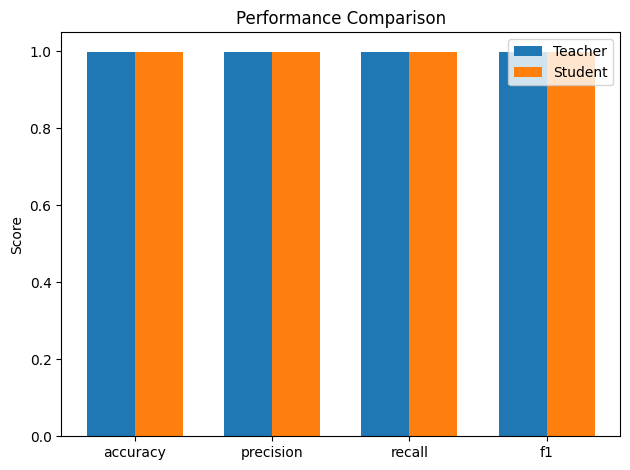

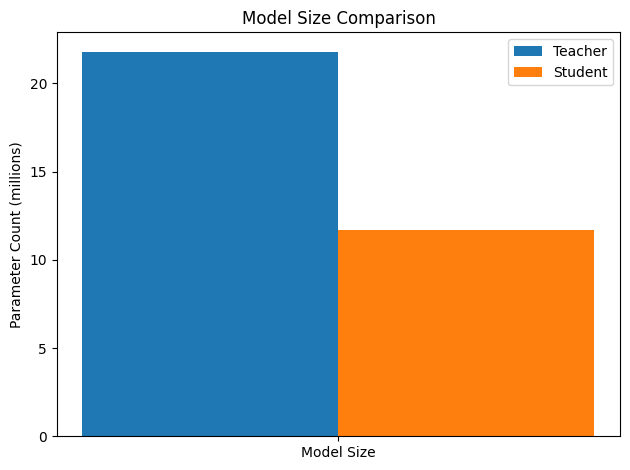

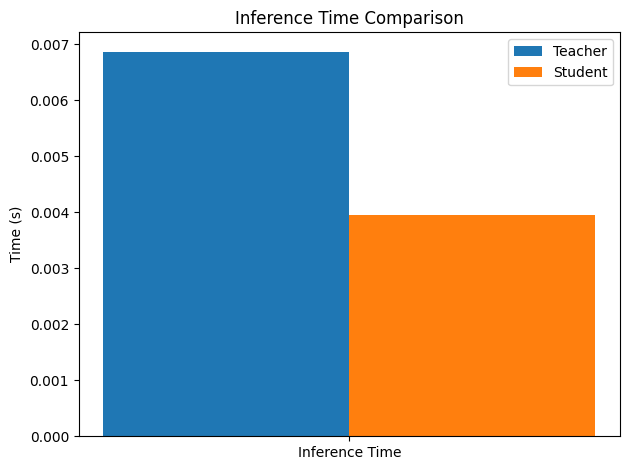

In [11]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

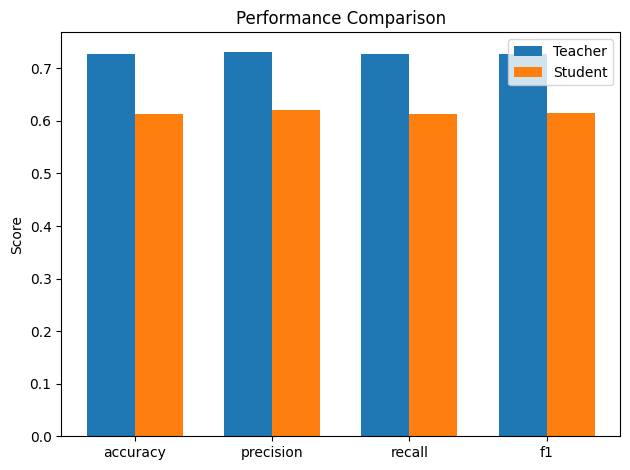

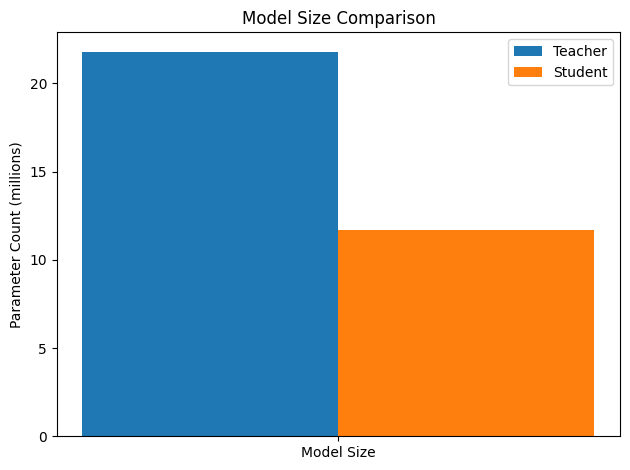

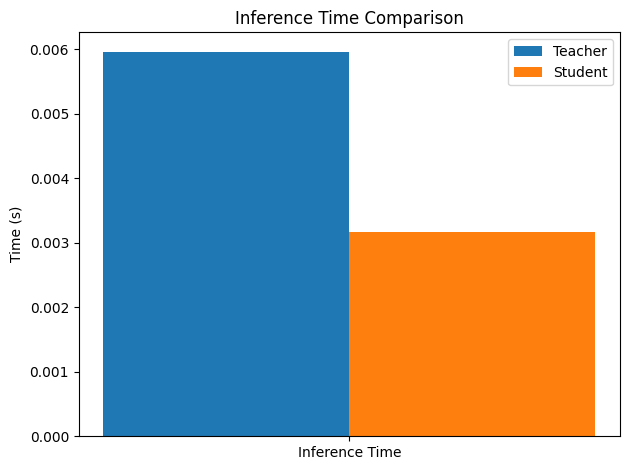

In [12]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')